# Part 2 - ImageIO

## File reading and writing

In [1]:
import skimage
from skimage import io, draw

import matplotlib
import numpy as np

In [2]:
# io.imread() is simple to use. In most cases, you just need the file path
jax = io.imread('data/jax.jpeg') 
io.imshow(jax);

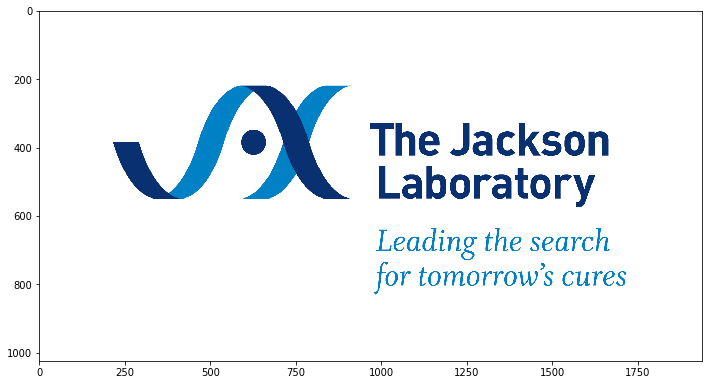

In [3]:
matplotlib.rcParams['figure.figsize'] = [10.0, 10.0] #resizing output
io.imshow(jax);

In [4]:
print('# Dimensions: ',jax.ndim)
print('       Shape: ', jax.shape)
print('        Type: ', jax.dtype)

# Dimensions:  3
       Shape:  (1024, 1938, 3)
        Type:  uint8


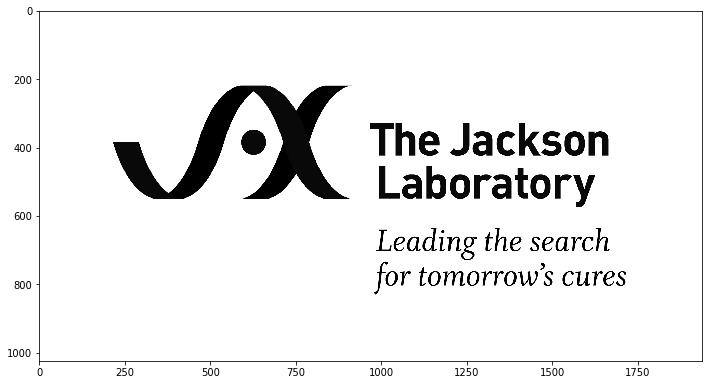

In [5]:
jax_bw = jax[:,:,0] #remember, this is the red channel
io.imshow(jax_bw);

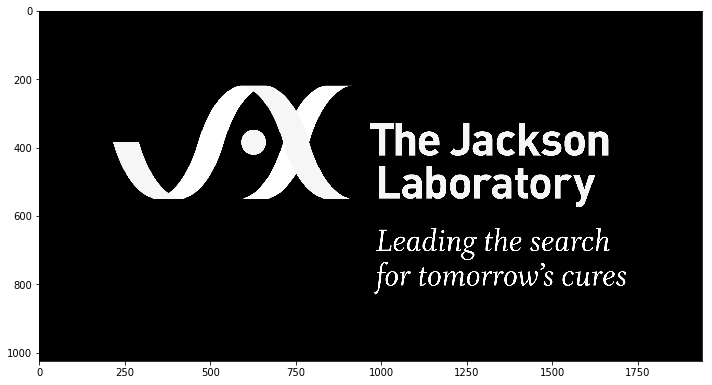

In [6]:
# You can invert the b&w image
jax_invert = skimage.util.invert(jax_bw)
io.imshow(jax_invert);

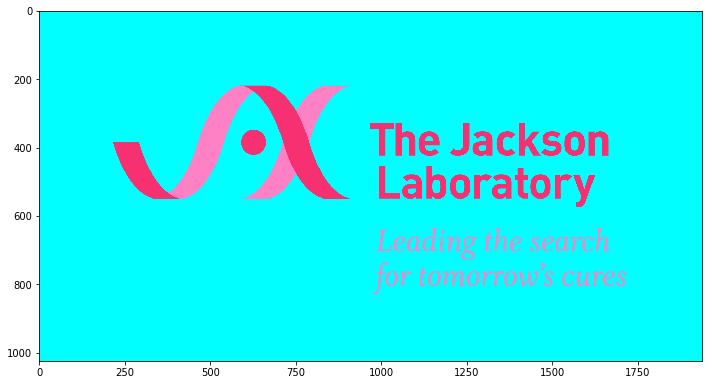

In [7]:
# What happens if we replace the red channel in the original image with the inverted red channel?
jax[:,:,0] = jax_invert
io.imshow(jax);

In [8]:
# Now to write out this new image.
#You might get some warnings, but it should work
io.imsave('jax2.jpeg', jax)
io.imsave('jax2.tif', jax)

## Drawing

/anaconda3/envs/ImPyClass2/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


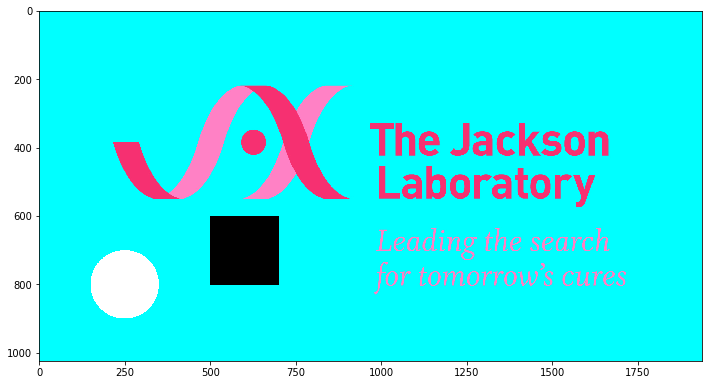

In [9]:
# skimage.draw has methods for creating shapes. It outputs
#indices, so you use it like np.where()

circle_indices = draw.circle(800,250,radius=100)#input center of circle and radius
jax[circle_indices] = [255,255,255]

square_indices = draw.rectangle([600,500], [800,700]) #input corners
jax[square_indices] = [0,0,0]


io.imshow(jax);

## Working with 3D images

In [10]:
#Now lets read in an image "stack". This is a 3-dimensional image!
#The different image "planes" in the stack are different focal planes.
bf = io.imread('data/bf_stack.tif')

# Image captured by Elise Courtois

In [11]:
bf.shape

(40, 442, 422)

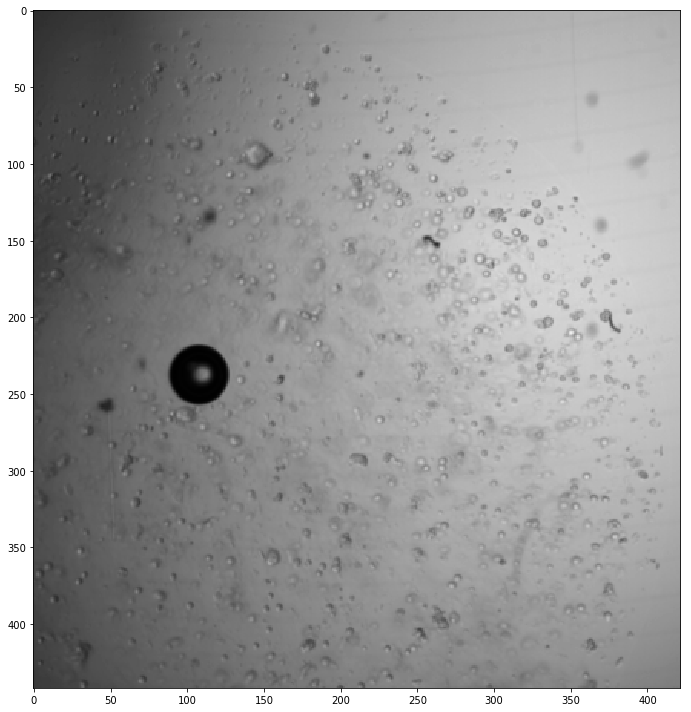

In [12]:
# look at the first image in the stack
io.imshow(bf[0,:,:]);

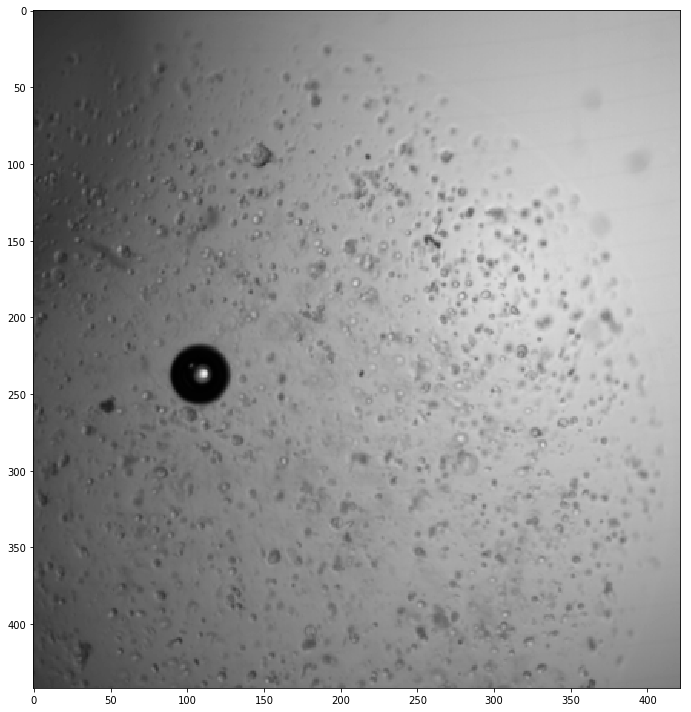

In [13]:
# here is a deeper focal plane
io.imshow(bf[10,:,:]);

## Exercises

1. Produce max and min projections for `bf_vol` along each axis, and save each as a tif.
2. Create a max projection (axis=0) of a color-inverted `bf_vol` and crop it to the lower left quadrant.
3. Save the output of \#2 as a jpeg.

## Using PIL to load only part of an image

In [14]:
import sys
from PIL import Image

In [15]:
# when we are loading in images is numpy.ndarrays, they take up a good chunk of memory
# this can be a problem for very large image files
print('          type: ', type(bf))
print('size in memory: ', sys.getsizeof(bf))

          type:  <class 'numpy.ndarray'>
size in memory:  7461088


In [16]:
# Instead we can open the image file and keep it accessible as a PIL Image file object
# This is really a file handle and contains very little data itself
bf2 = Image.open('data/bf_stack.tif')

In [17]:
# This has a very small memory footprint because it is just a file pointer
print('          type: ', type(bf2))
print('size in memory: ', sys.getsizeof(bf2))

          type:  <class 'PIL.TiffImagePlugin.TiffImageFile'>
size in memory:  56


In [18]:
# You can get a lot of information about the file without loading it into memory
print('          file format: ', bf2.format_description)
print('image planes in stack: ', bf2.n_frames)
print('              xy size: ', bf2.size)

          file format:  Adobe TIFF
image planes in stack:  40
              xy size:  (422, 442)


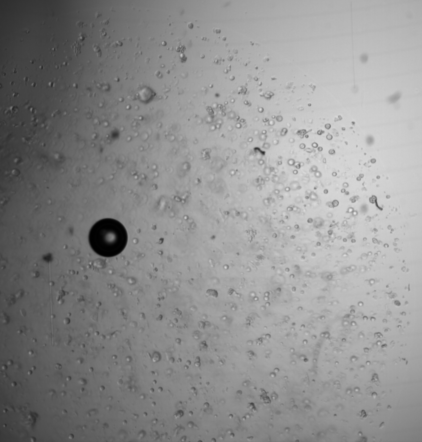

In [19]:
# entering bf2 give you the first focal plane of the image
# Note that PIL works differently from scikit-image
bf2

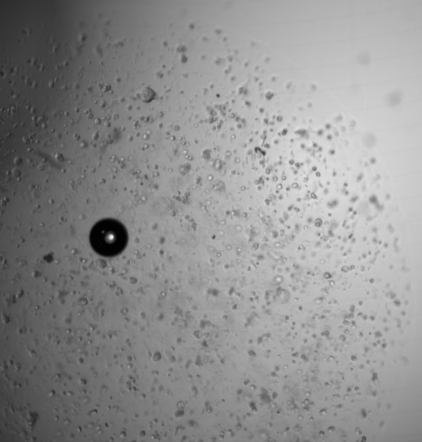

In [20]:
# If you want a different plane, use the seek() function
bf2.seek(10) #move the file pointer to plane #10
bf2

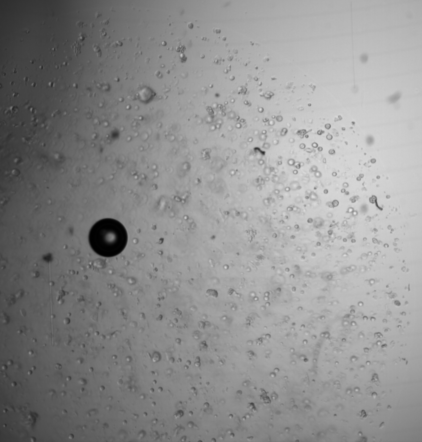

In [21]:
bf2.seek(0) #move the file pointer back to 0
bf2

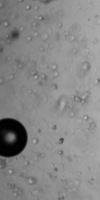

In [22]:
# Sometimes you really only need part of an image
bf2.crop([100,100,200,300]) #[x start, y start, x end, y end]

In [23]:
#notice that calling the PIL image is not returning an array
#you can convert to a np.array quite easily
bf2_array = np.array(bf2)
bf2_array

array([[ 46,  46,  46, ..., 170, 170, 170],
       [ 46,  46,  46, ..., 172, 171, 171],
       [ 46,  46,  46, ..., 172, 172, 171],
       ...,
       [ 57,  58,  58, ..., 126, 126, 125],
       [ 57,  58,  58, ..., 125, 124, 124],
       [ 56,  57,  58, ..., 122, 123, 122]], dtype=uint8)

In [24]:
# When you're done with a PIL image file object, be sure to close it!
bf2.close()

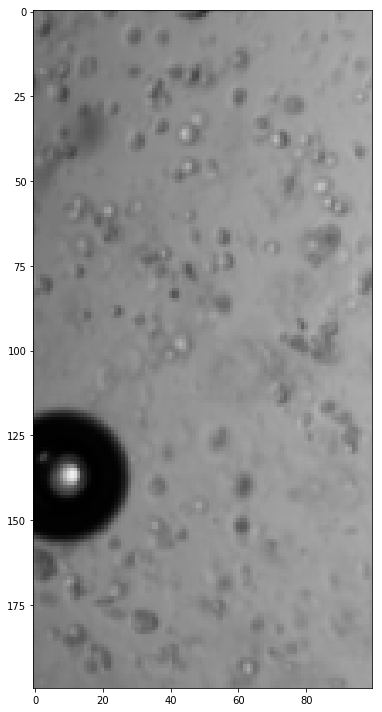

In [25]:
# We can define a function that will simplify 
#the process of loading only part of an image

def imread_crop(fname, crop, plane=0):
    with Image.open(fname) as im:
        im.seek(plane)
        im_array = np.array(im.crop(crop))
    return im_array

cropped_image = imread_crop('data/bf_stack.tif', [100,100,200,300], 10)
io.imshow(cropped_image);

          file format:  Adobe TIFF
image planes in stack:  40
              xy size:  (422, 442)
    image type (mode):  L
      additional info:  {'compression': 'raw', 'dpi': (1968.8809999999999, 1968.8809999999999)}


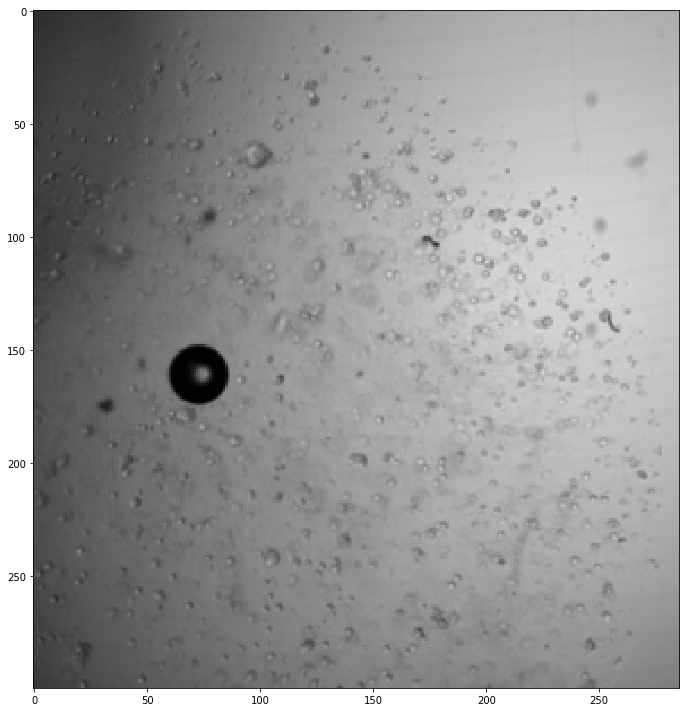

In [26]:
# Now we'll create a function to inspect the image attributes
#without loading it into memory as well as a function to provide
#a 'thumbnail' view of the image

def inspect_image(fname):
    with Image.open(fname) as im:
        # These are all attributes of PIL image objects
        print('          file format: ', im.format_description)
        print('image planes in stack: ', im.n_frames)
        print('              xy size: ', im.size)
        print('    image type (mode): ', im.mode) #https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
        print('      additional info: ', im.info)
        
def make_thumb(fname):
    with Image.open(fname) as im:
        im.thumbnail(size = [300,300]) #this is a method for PIL images only...we'll only use it here
        im_array = np.array(im)
    return im_array
        
inspect_image('data/bf_stack.tif')
thumb = make_thumb('data/bf_stack.tif')
io.imshow(thumb); #Note this is a lower resolution than above

## Large files - Demo only

In [27]:
ls -hl ../data/GB.tif #This is a shell command, not Python!

ls: ../data/GB.tif: No such file or directory


In [28]:
# What happens to your RAM when you open using imread()?
#We'll check memory after this block
big_mem = io.imread('data/GB.tif') 

In [29]:
big_mem2 = big_mem.copy() #This doubles the memory footprint!

In [30]:
# Now lets try learning about the details of this image before
#loading it into memory. Bur first, we need to deactivate
#a PIL safety feature to open really big images
Image.MAX_IMAGE_PIXELS = None
inspect_image('data/GB.tif')

          file format:  Adobe TIFF
image planes in stack:  1
              xy size:  (35124, 43828)
    image type (mode):  L
      additional info:  {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}


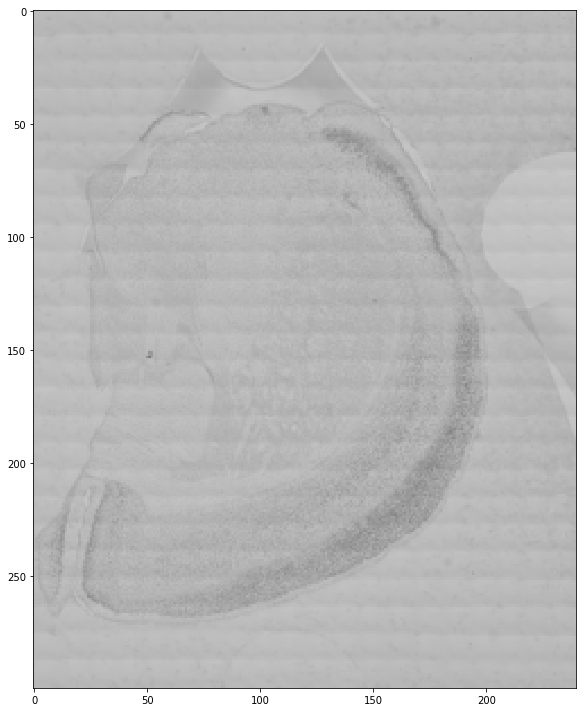

In [31]:
# A thumbnail overview can help to understand the image content
big_thumb = make_thumb('data/GB.tif')
io.imshow(big_thumb); #this unsurprisingly looks bad, but remember it is downscaled!

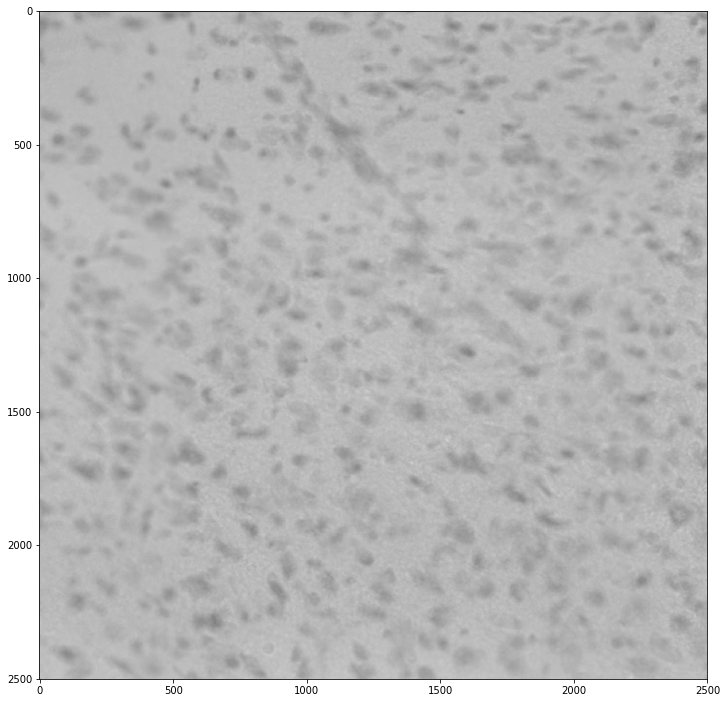

In [32]:
# Now we can just work with pieces of the large image at a time
big_crop = imread_crop('data/GB.tif', [10000,8000,12500,10500])
io.imshow(big_crop);